[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\User\AppData\Local\Temp\ipykernel_16584\2260659691.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["label"] = filtered_data["sentimen"].map(sentimen_map)


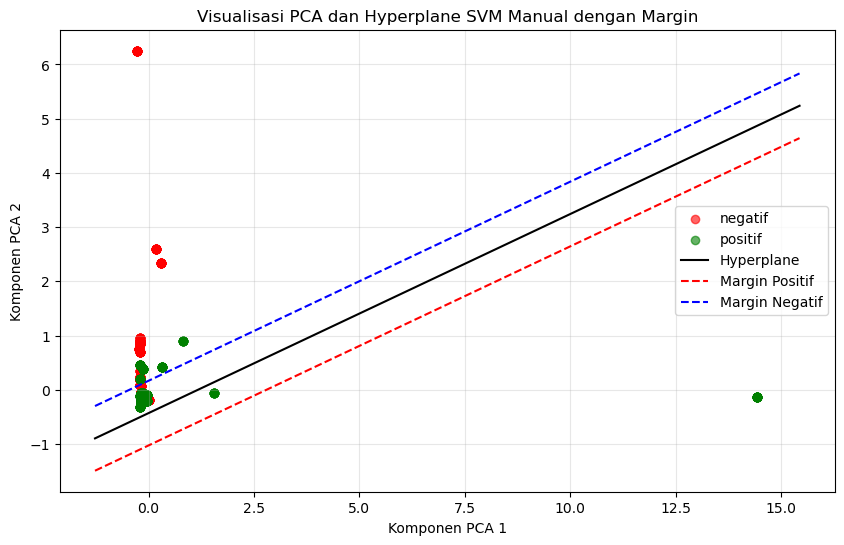

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import numpy as np

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Tokenisasi dan pembersihan data
stop_words = set(stopwords.words('indonesian'))

def preprocess_comment(comment):
    tokens = word_tokenize(comment.lower())
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return " ".join(tokens)

def train_svm_manual(X, y, learning_rate=0.001, epochs=1000, lambda_param=0.01):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    bias = 0

    for epoch in range(epochs):
        for idx, x_i in enumerate(X):
            condition = y[idx] * (np.dot(x_i, weights) - bias) >= 1
            if condition:
                weights -= learning_rate * (2 * lambda_param * weights)
            else:
                weights -= learning_rate * (2 * lambda_param * weights - np.dot(x_i, y[idx]))
                bias -= learning_rate * y[idx]

    return weights, bias

def predict_svm_manual(X, weights, bias):
    linear_output = np.dot(X, weights) - bias
    return np.sign(linear_output)

# Membaca data latih dari file Excel
data_train = pd.read_excel("data_latih_labeled.xlsx")

# Preprocessing komentar pada data latih
data_train["processed_komentar"] = data_train["komentar"].apply(preprocess_comment)

# Memetakan sentimen ke format numerik untuk pelatihan
sentimen_map = {"positif": 1, "negatif": -1, "netral": 0}  # Menggunakan -1 untuk SVM manual
filtered_data = data_train[data_train["sentimen"] != "netral"]  # Hapus data "netral"
filtered_data["label"] = filtered_data["sentimen"].map(sentimen_map)

# Vektorisasi komentar
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(filtered_data["processed_komentar"]).toarray()
y = filtered_data["label"].values

# Visualisasi PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
colors = ['red', 'green']
labels = ["negatif", "positif"]

for label, color in zip([-1, 1], colors):
    plt.scatter(X_pca[y == label, 0], X_pca[y == label, 1], c=color, label=labels[int((label + 1) / 2)], alpha=0.6)

# Training SVM Manual
weights, bias = train_svm_manual(X_pca, y)

# Plot hyperplane
xx = np.linspace(X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1, 200)
y_hyperplane = -(weights[0] * xx + bias) / weights[1]
y_margin1 = -(weights[0] * xx + bias - 1) / weights[1]
y_margin2 = -(weights[0] * xx + bias + 1) / weights[1]

plt.plot(xx, y_hyperplane, "k-", label="Hyperplane")
plt.plot(xx, y_margin1, "r--", label="Margin Positif")
plt.plot(xx, y_margin2, "b--", label="Margin Negatif")

plt.title("Visualisasi PCA dan Hyperplane SVM Manual dengan Margin")
plt.xlabel("Komponen PCA 1")
plt.ylabel("Komponen PCA 2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


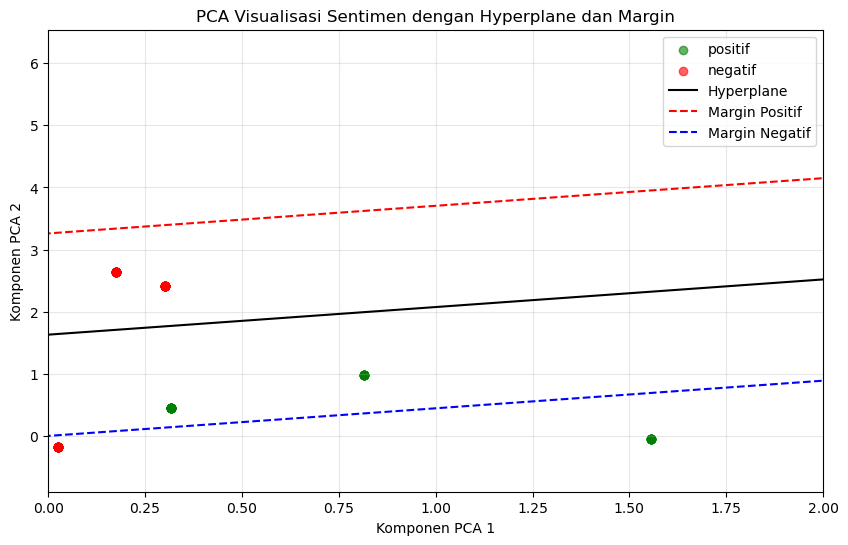

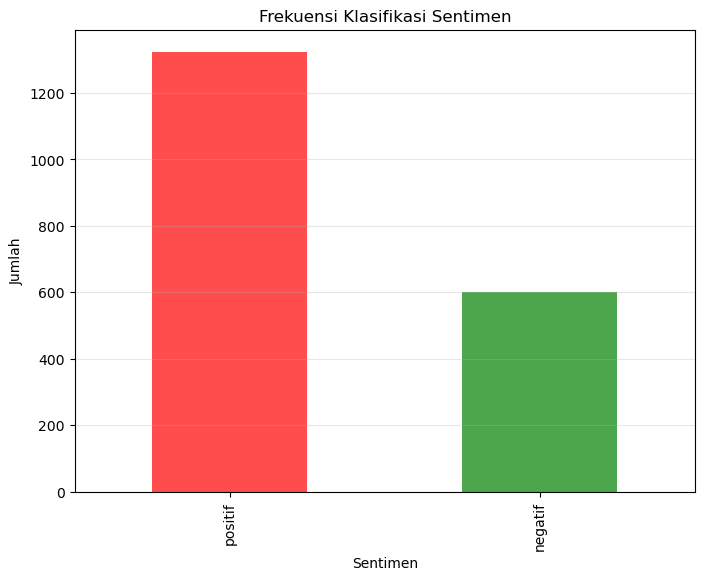

Tabel hasil klasifikasi disimpan di 'classification_results.xlsx'.
Hasil prediksi data uji disimpan di 'data_uji_prediksi.xlsx'.


In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import numpy as np

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Tokenisasi dan pembersihan data
stop_words = set(stopwords.words('indonesian'))

def preprocess_comment(comment):
    tokens = word_tokenize(comment.lower())
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return " ".join(tokens)

# Membaca data uji dari file Excel
data_test = pd.read_excel("data_uji_test.xlsx")  # Data uji tanpa label

# Preprocessing komentar pada data uji
data_test["processed_komentar"] = data_test["komentar"].apply(preprocess_comment)

# Memuat model dan vectorizer yang sudah ada
with open("svm_model.pkl", "rb") as model_file:
    svm_model = pickle.load(model_file)

with open("vectorizer.pkl", "rb") as vectorizer_file:
    vectorizer = pickle.load(vectorizer_file)

# Prediksi pada data uji
X_test_unlabeled = vectorizer.transform(data_test["processed_komentar"])
data_test["prediksi_label"] = svm_model.predict(X_test_unlabeled)

# Mengubah label netral menjadi negatif
data_test["prediksi_label"] = data_test["prediksi_label"].replace(0, -1)

# Mengembalikan label numerik ke kategori
label_map_reverse = {1: "positif", -1: "negatif"}
data_test["prediksi_sentimen"] = data_test["prediksi_label"].map(label_map_reverse)

# Visualisasi PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_unlabeled.toarray())

plt.figure(figsize=(10, 6))
colors = {"positif": "green", "negatif": "red"}
for sentiment in label_map_reverse.values():
    indices = data_test[data_test["prediksi_sentimen"] == sentiment].index
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], c=colors[sentiment], label=sentiment, alpha=0.6)

# Proyeksikan bobot SVM ke ruang PCA
original_weights = svm_model.coef_.toarray()[0]
pca_weights = pca.components_.dot(original_weights)
pca_bias = svm_model.intercept_[0]

# Hyperplane dan Margin untuk PCA
xx = np.linspace(X_pca[:, 0].min() - 1, min(X_pca[:, 0].max() + 1, 5), 200)
y_hyperplane = -(pca_weights[0] * xx + pca_bias) / pca_weights[1]
y_margin1 = -(pca_weights[0] * xx + pca_bias - 1) / pca_weights[1]
y_margin2 = -(pca_weights[0] * xx + pca_bias + 1) / pca_weights[1]

plt.plot(xx, y_hyperplane, "k-", label="Hyperplane")
plt.plot(xx, y_margin1, "r--", label="Margin Positif")
plt.plot(xx, y_margin2, "b--", label="Margin Negatif")

plt.xlim(0, 2)  # Membatasi rentang sumbu x hingga 5
plt.title("PCA Visualisasi Sentimen dengan Hyperplane dan Margin")
plt.xlabel("Komponen PCA 1")
plt.ylabel("Komponen PCA 2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Frekuensi Klasifikasi Sentimen
sentiment_counts = data_test["prediksi_sentimen"].value_counts()
sentiment_counts.plot(kind="bar", color=["red", "green"], alpha=0.7, figsize=(8, 6))
plt.title("Frekuensi Klasifikasi Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.grid(axis="y", alpha=0.3)
plt.show()

# Tabel hasil klasifikasi
classification_table = data_test[["komentar", "prediksi_sentimen"]]
classification_table.to_excel("classification_results.xlsx", index=False)
print("Tabel hasil klasifikasi disimpan di 'classification_results.xlsx'.")

# Menyimpan hasil prediksi data uji
data_test.to_excel("data_uji_prediksi.xlsx", index=False)
print("Hasil prediksi data uji disimpan di 'data_uji_prediksi.xlsx'.")
